In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the ML pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute  import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score

# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer

from feature_engine.categorical_encoders import RareLabelCategoricalEncoder

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [3]:
# load dataset
# remember to download the data set  from Kaggle and save it into 
# the same folder from where you run this notebook

data = pd.read_csv('houseprice.csv')

print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Separate dataset into train and test

Before beginning to engineer our features, it is important to separate our data intro training and testing set. This is to avoid over-fitting. This step involves randomness, therefore, we need to set the seed.

In [4]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('SalePrice', axis=1), # predictors
    data.SalePrice, # target
    test_size=0.1,
    random_state=0)  # for reproducibility

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1314, 80), (146, 80), (1314,), (146,))

### Missing values

In [5]:
# make lists capturing the different variables types in our dataset:
# -----------------------------------------
# one list to capture date variables
# one list to capture categorical variables
# one list to capture numerical variables

vars_dates = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
vars_cat = [var for var in X_train.columns if X_train[var].dtypes == 'O']
vars_num = [var for var in X_train.columns if X_train[var].dtypes !=
            'O' and var not in ['Id']]

In [6]:
# check for missing values in our date variables

X_train[vars_dates].isnull().mean().sort_values(ascending=False)

GarageYrBlt     0.056317
YearRemodAdd    0.000000
YearBuilt       0.000000
dtype: float64

In [7]:
# check for missing values in our numerical variables

X_train[vars_num].isnull().mean().sort_values(ascending=False)

LotFrontage      0.177321
GarageYrBlt      0.056317
MasVnrArea       0.004566
YrSold           0.000000
BsmtFinSF2       0.000000
LowQualFinSF     0.000000
2ndFlrSF         0.000000
1stFlrSF         0.000000
TotalBsmtSF      0.000000
BsmtUnfSF        0.000000
BsmtFinSF1       0.000000
BsmtFullBath     0.000000
YearRemodAdd     0.000000
YearBuilt        0.000000
OverallCond      0.000000
OverallQual      0.000000
LotArea          0.000000
GrLivArea        0.000000
BsmtHalfBath     0.000000
MoSold           0.000000
WoodDeckSF       0.000000
MiscVal          0.000000
PoolArea         0.000000
ScreenPorch      0.000000
3SsnPorch        0.000000
EnclosedPorch    0.000000
OpenPorchSF      0.000000
GarageArea       0.000000
FullBath         0.000000
GarageCars       0.000000
Fireplaces       0.000000
TotRmsAbvGrd     0.000000
KitchenAbvGr     0.000000
BedroomAbvGr     0.000000
HalfBath         0.000000
MSSubClass       0.000000
dtype: float64

In [8]:
# check for missing values in our categorical variables

X_train[vars_cat].isnull().mean().sort_values(ascending=False)

PoolQC           0.995434
MiscFeature      0.961187
Alley            0.938356
Fence            0.814307
FireplaceQu      0.472603
GarageCond       0.056317
GarageQual       0.056317
GarageFinish     0.056317
GarageType       0.056317
BsmtFinType2     0.025114
BsmtExposure     0.025114
BsmtFinType1     0.024353
BsmtQual         0.024353
BsmtCond         0.024353
MasVnrType       0.004566
Electrical       0.000761
Condition2       0.000000
Condition1       0.000000
Neighborhood     0.000000
LandSlope        0.000000
BldgType         0.000000
LandContour      0.000000
LotConfig        0.000000
Utilities        0.000000
RoofStyle        0.000000
LotShape         0.000000
Street           0.000000
HouseStyle       0.000000
SaleCondition    0.000000
RoofMatl         0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
ExterQual        0.000000
ExterCond        0.000000
Foundation       0.000000
SaleType         0.000000
Heating          0.000000
HeatingQC        0.000000
CentralAir  

In [9]:
# removing missing data
# --------------------
# imputation numerical variables
imputer = SimpleImputer(strategy='constant', fill_value=-1)
X_train['LotFrontage'] = imputer.fit_transform(X_train['LotFrontage'].to_frame())
X_test['LotFrontage'] = imputer.transform(X_test['LotFrontage'].to_frame())

imputer = SimpleImputer(strategy='most_frequent')
X_train[vars_num] = imputer.fit_transform(X_train[vars_num])
X_test[vars_num] = imputer.transform(X_test[vars_num])

In [10]:
# imputation categorical variables
imputer = SimpleImputer(strategy='constant', fill_value='missing')
X_train[vars_cat] = imputer.fit_transform(X_train[vars_cat])
X_test[vars_cat] = imputer.transform(X_test[vars_cat])

### Temporal variables

In [11]:
# let's create new temporal features from our date variables


def elapsed_years(df, var):
    # capture difference between year variable and year the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [12]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [13]:
# check that test set does not contain null values in the engineered variables
[vr for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'] if X_test[var].isnull().sum()>0]

[]

### Categorical variable encoding

In [14]:
[var for var in X_train.columns if X_train[var].isnull().sum()>0]

[]

In [15]:
[var for var in X_train.columns if X_test[var].isnull().sum()>0]

[]

In [16]:
# remove rare caregories

rare_enc = RareLabelCategoricalEncoder(tol=0.01, n_categories=5, variables = vars_cat)
rare_enc.fit(X_train)
X_train = rare_enc.transform(X_train)
X_test = rare_enc.transform(X_test)

In [17]:
# encode with labels

ordinal_enc = OrdinalEncoder()
X_train[vars_cat] = ordinal_enc.fit_transform(X_train[vars_cat])
X_test[vars_cat] = ordinal_enc.transform(X_test[vars_cat])

In [18]:
[var for var in X_train.columns if X_test[var].isnull().sum()>0]

[]

In [19]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
930,931,20.0,3.0,73.0,8925.0,1.0,2.0,0.0,1.0,0.0,4.0,0.0,22.0,2.0,0.0,0.0,1.0,8.0,5.0,2.0,2.0,0.0,0.0,8.0,8.0,2.0,0.0,2.0,4.0,2.0,2.0,3.0,0.0,2.0,16.0,5.0,0.0,1450.0,1466.0,0.0,0.0,1.0,3.0,1466.0,0.0,0.0,1466.0,0.0,0.0,2.0,0.0,3.0,1.0,2.0,7.0,4.0,0.0,5.0,0.0,2.0,0.0,3.0,610.0,2.0,2.0,2.0,100.0,18.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,0.0,7.0,2009.0,3.0,2.0
656,657,20.0,3.0,72.0,10007.0,1.0,2.0,0.0,3.0,0.0,4.0,0.0,11.0,2.0,0.0,0.0,1.0,5.0,7.0,49.0,2.0,0.0,0.0,3.0,3.0,1.0,54.0,2.0,4.0,1.0,3.0,3.0,3.0,0.0,806.0,5.0,0.0,247.0,1053.0,0.0,0.0,1.0,3.0,1053.0,0.0,0.0,1053.0,1.0,0.0,1.0,1.0,3.0,1.0,2.0,5.0,4.0,0.0,5.0,0.0,49.0,1.0,1.0,312.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,4.0,0.0,8.0,2008.0,3.0,2.0
45,46,120.0,3.0,61.0,7658.0,1.0,2.0,3.0,3.0,0.0,4.0,0.0,14.0,2.0,0.0,4.0,1.0,9.0,5.0,5.0,5.0,1.0,0.0,4.0,4.0,1.0,412.0,0.0,4.0,2.0,0.0,3.0,3.0,2.0,456.0,5.0,0.0,1296.0,1752.0,0.0,0.0,1.0,3.0,1752.0,0.0,0.0,1752.0,1.0,0.0,2.0,0.0,2.0,1.0,0.0,6.0,4.0,1.0,2.0,0.0,5.0,1.0,2.0,576.0,2.0,2.0,2.0,196.0,82.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,0.0,2.0,2010.0,3.0,2.0
1348,1349,20.0,3.0,-1.0,16196.0,1.0,2.0,2.0,2.0,0.0,4.0,0.0,19.0,2.0,0.0,0.0,1.0,7.0,5.0,9.0,9.0,0.0,0.0,8.0,8.0,2.0,0.0,2.0,4.0,2.0,2.0,3.0,1.0,2.0,1443.0,5.0,0.0,39.0,1482.0,0.0,0.0,1.0,3.0,1494.0,0.0,0.0,1494.0,1.0,0.0,2.0,0.0,3.0,1.0,2.0,5.0,4.0,1.0,1.0,0.0,9.0,1.0,2.0,514.0,2.0,2.0,2.0,402.0,25.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,0.0,8.0,2007.0,3.0,2.0
55,56,20.0,3.0,100.0,10175.0,1.0,2.0,0.0,3.0,0.0,4.0,0.0,11.0,2.0,0.0,0.0,1.0,6.0,5.0,44.0,44.0,0.0,0.0,3.0,5.0,1.0,272.0,3.0,4.0,1.0,3.0,3.0,3.0,1.0,490.0,5.0,0.0,935.0,1425.0,0.0,2.0,1.0,3.0,1425.0,0.0,0.0,1425.0,0.0,0.0,2.0,0.0,3.0,1.0,3.0,7.0,4.0,1.0,2.0,0.0,44.0,1.0,2.0,576.0,2.0,2.0,2.0,0.0,0.0,0.0,407.0,0.0,0.0,3.0,4.0,4.0,0.0,7.0,2008.0,3.0,2.0


## Gradient boosting regressor

In [20]:
tree_reg = GradientBoostingRegressor(random_state=0, n_estimators=50)
tree_reg.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [21]:
# evaluate the model:

# We will evaluate performance using the mean squared error and the
# root of the mean squared error

pred = tree_reg.predict(X_train)
print('linear train mse: {}'.format(mean_squared_error(y_train, pred)))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred))))
print()
pred = tree_reg.predict(X_test)
print('linear test mse: {}'.format(mean_squared_error(y_test, pred)))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred))))

linear train mse: 319335295.90204245
linear train rmse: 17869.955117516172

linear test mse: 1100602976.041241
linear test rmse: 33175.33686402055


In [22]:
# These are the values produced by our current live model
# we new them from the past, so I pase them here for information

print('''
Prediction analysis from old Lasso Regression:
---------------------------------------------
linear train mse: 1087435415.4414542
linear train rmse: 32976.28565259366

linear test mse: 1405259552.2596064
linear test rmse: 37486.79170400698
''')


Prediction analysis from old Lasso Regression:
---------------------------------------------
linear train mse: 1087435415.4414542
linear train rmse: 32976.28565259366

linear test mse: 1405259552.2596064
linear test rmse: 37486.79170400698



Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

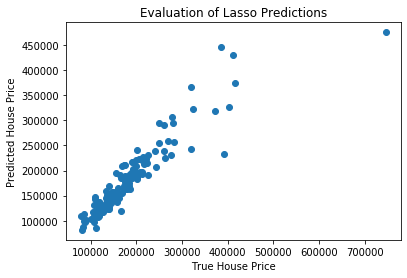

In [23]:
# let's evaluate our predictions respect to the original price

plt.scatter(y_test, tree_reg.predict(X_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Predictions')

## Feature Selection

In [24]:
# here I will do the model fitting and feature selection
# altogether in one line of code

# To select features we use Scikit-learn's SelectFromModel
# specifying the the Gradient Boosting Regressor model

# and we train the SelecgFromModel with the train set.

# remember to set the seed, the random state in this function
sel_ = SelectFromModel(GradientBoostingRegressor(
    random_state=0, n_estimators=50))
sel_.fit(X_train, y_train)

SelectFromModel(estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                    criterion='friedman_mse',
                                                    init=None,
                                                    learning_rate=0.1,
                                                    loss='ls', max_depth=3,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=50,
                                      

In [25]:
# let's print the number of total and selected features

# this is how we can make a list of the selected features
selected_feat = X_train.columns[(sel_.get_support())]

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 80
selected features: 10


In [26]:
selected_feat

Index(['LotArea', 'OverallQual', 'YearRemodAdd', 'BsmtQual', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageCars'],
      dtype='object')

## Re-build model with selected features

In [27]:
tree_reg = GradientBoostingRegressor(random_state=0, n_estimators=50)
tree_reg.fit(X_train[selected_feat], y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
pred = tree_reg.predict(X_train[selected_feat])
print('linear train mse: {}'.format(mean_squared_error(y_train, pred)))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred))))
print()
pred = tree_reg.predict(X_test[selected_feat])
print('linear test mse: {}'.format(mean_squared_error(y_test, pred)))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred))))

linear train mse: 418644251.8706319
linear train rmse: 20460.797928493204

linear test mse: 633153768.8943316
linear test rmse: 25162.54694768261


In [29]:
data[selected_feat].head()

,LotArea,OverallQual,YearRemodAdd,BsmtQual,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageCars
0,8450,7,2003,Gd,706,856,856,854,1710,2
1,9600,6,1976,Gd,978,1262,1262,0,1262,2
2,11250,7,2002,Gd,486,920,920,866,1786,2
3,9550,7,1970,TA,216,756,961,756,1717,3
4,14260,8,2000,Gd,655,1145,1145,1053,2198,3


In [30]:
# make a list of the categorical variables that contain missing values

vars_dates = ['YearRemodAdd']
vars_cat = ['BsmtQual']
vars_num = ['LotArea', 'OverallQual', 'YearRemodAdd', 'BsmtQual', 'BsmtFinSF1',
            'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageCars']